In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, 
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import cv2
import os
from pathlib import Path
from tqdm import tqdm

alphabet_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
                   "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

print("Loading images from dataset...")
image_data = []
label_data = []

data_directory = Path('data/asl_alphabet_train')
image_size = 64

for letter in alphabet_labels:
    letter_folder = data_directory / letter
    if letter_folder.exists():
        image_files = list(letter_folder.glob("*.jpg")) + list(letter_folder.glob("*.JPG")) + \
                     list(letter_folder.glob("*.jpeg")) + list(letter_folder.glob("*.JPEG"))
        
        label_index = alphabet_labels.index(letter)
        
        print(f"Loading {len(image_files)} images for letter '{letter}'...")
        
        for img_path in tqdm(image_files, desc=f"  {letter}", leave=False):
            img = cv2.imread(str(img_path))
            if img is not None:
                img_resized = cv2.resize(img, (image_size, image_size))
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                image_data.append(img_rgb)
                label_data.append(label_index)
    else:
        print(f"Warning: {letter_folder} not found")

X = np.array(image_data)
y = np.array(label_data)

print(f"\nLoaded {len(X)} images")
print(f"Image shape: {X.shape}")

X = X.astype('float32') / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

y_train_categorical = to_categorical(y_train, num_classes=26)
y_test_categorical = to_categorical(y_test, num_classes=26)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

def create_small_vgg(input_shape=(64, 64, 3), num_classes=26):
    model = Sequential(name='small_vgg')
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print("\nCreating small VGG model...")
model = create_small_vgg(input_shape=(image_size, image_size, 3), num_classes=26)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\nStarting training...")
history = model.fit(
    X_train,
    y_train_categorical,
    batch_size=32,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(
    X_test,
    y_test_categorical,
    verbose=1
)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

model.save('vgg_asl_model.h5')
print("\nModel saved as 'vgg_asl_model.h5'")


Loading images from dataset...
Loading 8458 images for letter 'a'...


Loading 8309 images for letter 'b'...


Loading 8146 images for letter 'c'...


Loading 7629 images for letter 'd'...


Loading 7744 images for letter 'e'...


Loading 8031 images for letter 'f'...


Loading 7844 images for letter 'g'...


Loading 7906 images for letter 'h'...


Loading 7953 images for letter 'i'...


Loading 7503 images for letter 'j'...


Loading 7876 images for letter 'k'...


Loading 7939 images for letter 'l'...


Loading 7900 images for letter 'm'...


Loading 7932 images for letter 'n'...


Loading 8140 images for letter 'o'...


Loading 7601 images for letter 'p'...


Loading 7954 images for letter 'q'...


Loading 8021 images for letter 'r'...


Loading 8109 images for letter 's'...


Loading 8054 images for letter 't'...


Loading 8023 images for letter 'u'...


Loading 7597 images for letter 'v'...


Loading 7787 images for letter 'w'...


Loading 8093 images for letter 'x'...


Loading 8178 images for letter 'y'...


Loading 7410 images for letter 'z'...



Loaded 206137 images
Image shape: (206137, 64, 64, 3)
Training set shape: (185523, 64, 64, 3)
Test set shape: (20614, 64, 64, 3)

Creating small VGG model...


Model: "small_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,622,778 (17.63 MB)

 Trainable params: 4,621,306 (17.63 MB)

 Non-trainable params: 1,472 (5.75 KB)


Starting training...
Epoch 1/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 858s 164ms/step - accuracy: 0.6715 - loss: 1.0641 - val_accuracy: 0.9368 - val_loss: 0.2076
Epoch 2/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 881s 169ms/step - accuracy: 0.9012 - loss: 0.3085 - val_accuracy: 0.9638 - val_loss: 0.1123
Epoch 3/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 886s 170ms/step - accuracy: 0.9363 - loss: 0.2034 - val_accuracy: 0.9837 - val_loss: 0.0556
Epoch 4/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 883s 169ms/step - accuracy: 0.9524 - loss: 0.1542 - val_accuracy: 0.9852 - val_loss: 0.0436
Epoch 5/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 886s 170ms/step - accuracy: 0.9611 - loss: 0.1296 - val_accuracy: 0.9764 - val_loss: 0.0729
Epoch 6/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 913s 175ms/step - accuracy: 0.9676 - loss: 0.1085 - val_accuracy: 0.9927 - val_loss: 0.0229
Epoch 7/10
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 878s 168ms/step - accuracy: 0.9724 - loss: 0.0937 - val_accuracy: 0.9933 - val_loss: 0.0221
Epoch 8/10
5218/5218 ━━━━━━━━━━━━━━━━━━━


Test Accuracy: 0.9967
Test Loss: 0.0124

Model saved as 'vgg_asl_model.h5'


Loading model...
Model loaded successfully!

Loading images from dataset...



Test set shape: (20614, 64, 64, 3)
Number of test samples: 20614

Generating predictions on test set...
645/645 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step

Calculating confusion matrix...

Confusion matrix saved as 'confusion_matrix.png'


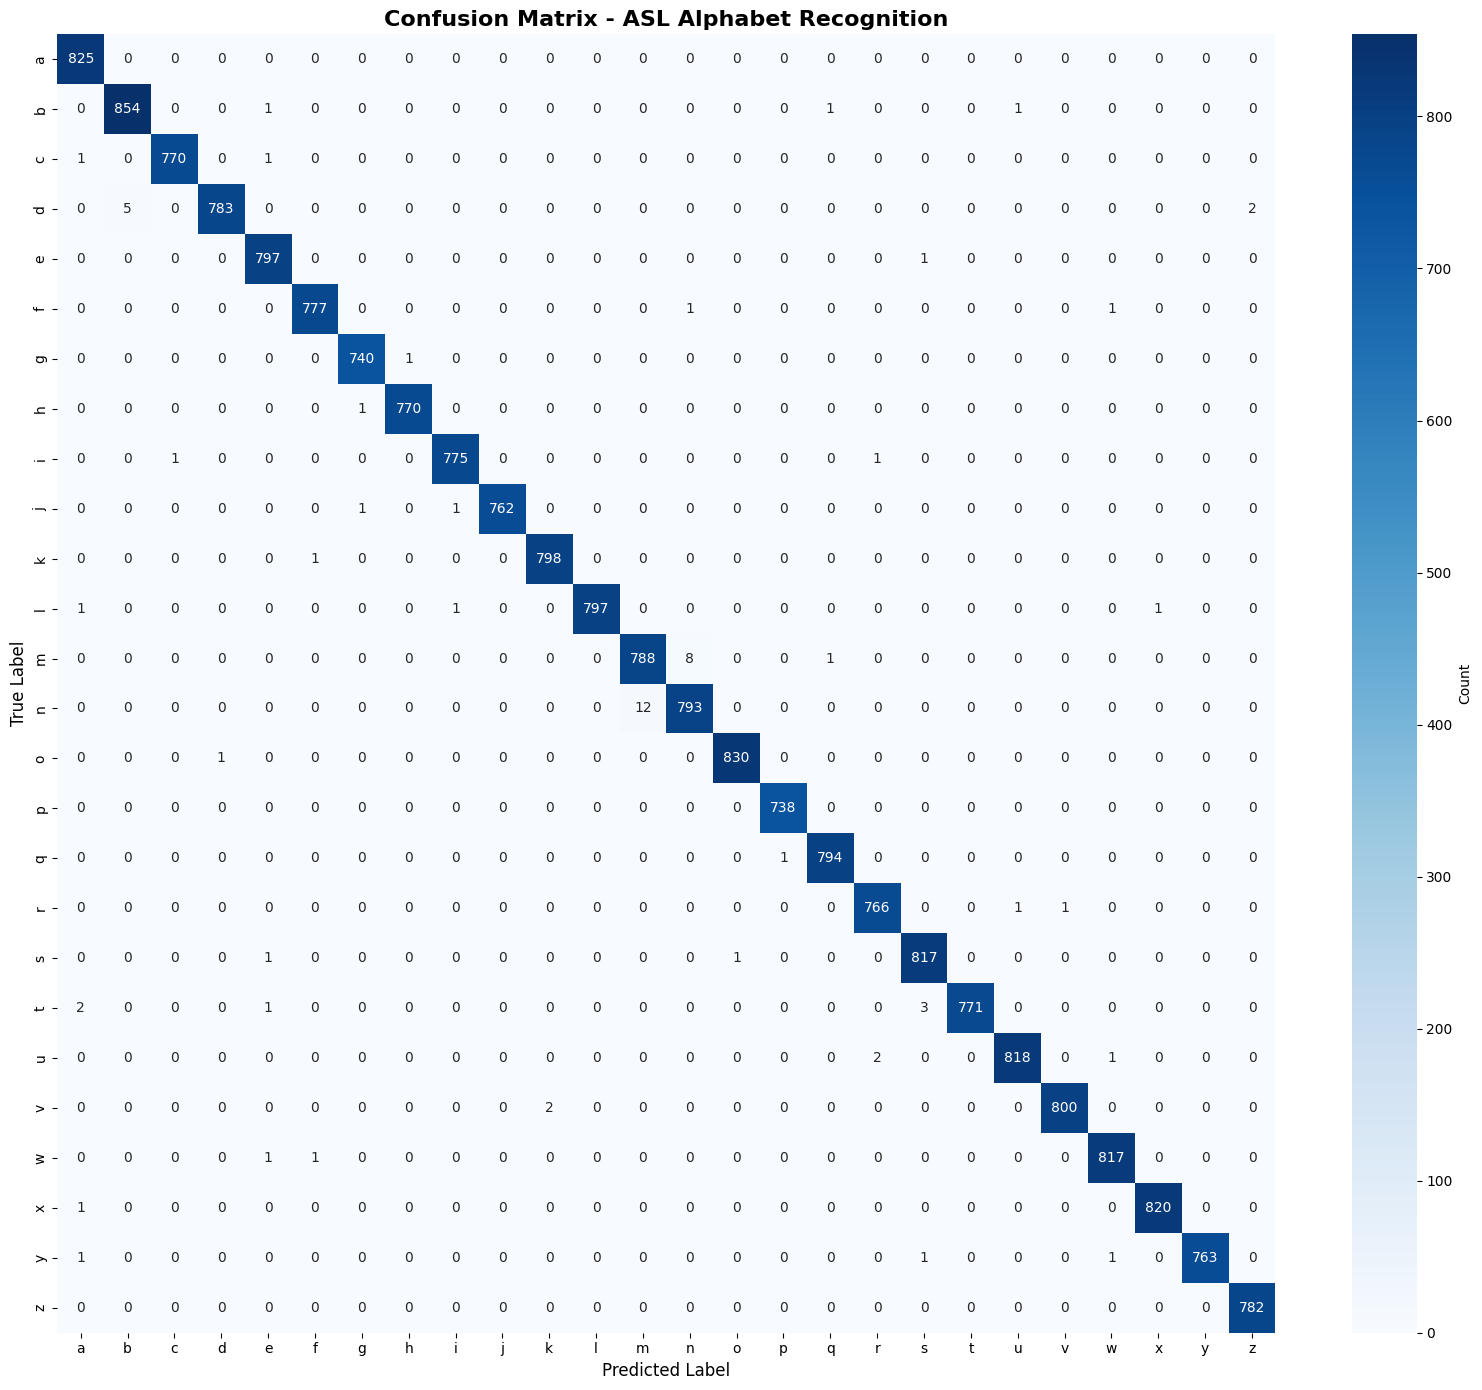


Classification Report:
              precision    recall  f1-score   support

           a       0.99      1.00      1.00       825
           b       0.99      1.00      1.00       857
           c       1.00      1.00      1.00       772
           d       1.00      0.99      0.99       790
           e       0.99      1.00      1.00       798
           f       1.00      1.00      1.00       779
           g       1.00      1.00      1.00       741
           h       1.00      1.00      1.00       771
           i       1.00      1.00      1.00       777
           j       1.00      1.00      1.00       764
           k       1.00      1.00      1.00       799
           l       1.00      1.00      1.00       800
           m       0.98      0.99      0.99       797
           n       0.99      0.99      0.99       805
           o       1.00      1.00      1.00       831
           p       1.00      1.00      1.00       738
           q       1.00      1.00      1.00       795
   

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load the saved model
print("Loading model...")
model = load_model('vgg_asl_model.h5')
print("Model loaded successfully!")

# Load test data (or reload all data and split)
alphabet_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
                   "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

print("\nLoading images from dataset...")
image_data = []
label_data = []

data_directory = Path('data/asl_alphabet_train')
image_size = 64

for letter in alphabet_labels:
    letter_folder = data_directory / letter
    if letter_folder.exists():
        image_files = list(letter_folder.glob("*.jpg")) + list(letter_folder.glob("*.JPG")) + \
                     list(letter_folder.glob("*.jpeg")) + list(letter_folder.glob("*.JPEG"))
        
        label_index = alphabet_labels.index(letter)
        
        for img_path in tqdm(image_files, desc=f"  {letter}", leave=False):
            img = cv2.imread(str(img_path))
            if img is not None:
                img_resized = cv2.resize(img, (image_size, image_size))
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                image_data.append(img_rgb)
                label_data.append(label_index)

X = np.array(image_data)
y = np.array(label_data)
X = X.astype('float32') / 255.0

# Split data with same random_state to get the same test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(f"\nTest set shape: {X_test.shape}")
print(f"Number of test samples: {len(X_test)}")

# Generate predictions
print("\nGenerating predictions on test set...")
y_pred_proba = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate confusion matrix
print("\nCalculating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)

# Create visualization
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=alphabet_labels, 
            yticklabels=alphabet_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ASL Alphabet Recognition', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=alphabet_labels))

# Calculate and print accuracy per class
print("\nPer-class Accuracy:")
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, letter in enumerate(alphabet_labels):
    print(f"{letter}: {class_accuracy[i]:.4f} ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})")

print(f"\nOverall Accuracy: {np.trace(cm) / np.sum(cm):.4f}")
